# OPTIMIZATION PROJECT 2



In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')

In [2]:
timeLimit = 3600

In [3]:
stock19 = pd.read_csv('stocks2019.csv')  # for portfolio construction
stock20 = pd.read_csv('stocks2020.csv')  # for performance analysis

In [4]:
return19 = stock19.set_index('X').pct_change()  # returns for stocks in 2019
return20 = stock20.set_index('X').pct_change()  # returns for stocks in 2020

## Stock selection
$y_j$ - binary, which stocks j from index are present in the fund (1 if j selected)

$x_{ij}$ - binary, which stock j in index is the best representative of stock i (1 if most similar)


objective
$$\max_{x,y}\sum_{i=1}^n \sum_{j=1}^n \rho_{ij}x_{ij}$$

constraints
$$\sum_{j=1}^n y_j=m$$
$$\sum_{j=1}^n x_{ij}=1 (i=1,2,...,n)$$
$$x_{ij}\leq y_j (i,j = 1,2,...,n)$$ 
$$x_{ij},y_j \in \{0,1\}$$

In [5]:
# correlation matrix for returns (this will be the coefficients in the objective function)
corr_mat = return19.drop(columns='NDX').corr()
corr_mat

,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
ATVI,1.000000,0.399939,0.365376,0.223162,0.216280,0.433097,0.426777,0.467076,0.203956,0.329355,...,0.322906,0.128241,0.464850,0.316549,0.259679,0.218149,0.311659,0.303077,0.043389,0.249667
ADBE,0.399939,1.000000,0.452848,0.368928,0.363370,0.552125,0.540404,0.598237,0.291978,0.473815,...,0.360392,0.201151,0.711339,0.541243,0.402171,0.228106,0.650430,0.361516,0.207403,0.289497
AMD,0.365376,0.452848,1.000000,0.301831,0.344252,0.418861,0.417254,0.549302,0.151452,0.503733,...,0.332776,0.210623,0.498342,0.330900,0.272983,0.281950,0.407626,0.438892,0.017283,0.478010
ALXN,0.223162,0.368928,0.301831,1.000000,0.332433,0.315993,0.307698,0.363170,0.342022,0.317040,...,0.257143,0.408936,0.350581,0.191489,0.522423,0.192720,0.416396,0.289908,0.047947,0.200356
ALGN,0.216280,0.363370,0.344252,0.332433,1.000000,0.248747,0.250316,0.399281,0.264599,0.328280,...,0.175957,0.128559,0.360886,0.251855,0.334978,0.219595,0.308968,0.284407,0.088059,0.253934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WBA,0.218149,0.228106,0.281950,0.192720,0.219595,0.232900,0.230603,0.288168,0.194490,0.347861,...,0.257049,0.145330,0.195475,0.126118,0.214585,1.000000,0.211641,0.296309,-0.130798,0.276643
WDAY,0.311659,0.650430,0.407626,0.416396,0.308968,0.379493,0.371826,0.424748,0.211712,0.351734,...,0.235045,0.269545,0.569672,0.401476,0.376047,0.211641,1.000000,0.315699,0.209240,0.254117
WDC,0.303077,0.361516,0.438892,0.289908,0.284407,0.328619,0.322110,0.419620,0.172623,0.602935,...,0.377215,0.126463,0.331916,0.308558,0.314773,0.296309,0.315699,1.000000,-0.076115,0.516958
XEL,0.043389,0.207403,0.017283,0.047947,0.088059,0.059930,0.052570,0.076724,0.137857,-0.047259,...,-0.172752,0.074686,0.280371,0.407770,0.191667,-0.130798,0.209240,-0.076115,1.000000,-0.117552


In [6]:
m = 5   
n = len(corr_mat.columns)
rhos = []   # list of all smiliarity scores (correlation)
for i in range(n):
    for j in range(n):
        rhos.append(corr_mat.iloc[i,j])

#### OBJECTIVE FUNCTION ####
## MAXIMIZE x1,1 + x1,2 + ... + x1,n + x2,1 + ... + x2,n + ... + xn,n + 0*(y1 + y2 + ... + yn)
## obj dimension is n*n + n ##

obj = np.array(rhos + [0] * n)   
obj.shape

(10100,)

In [7]:
#### CONSTRAINT MATRIX ####
A = np.zeros((1+n+n*n, len(obj)))

### ALL DECISION VARIABLES ARE BINARY ###
vtype = ['B'] * len(obj)
A.shape

(10101, 10100)

In [8]:
## first constraint: exactly m stocks to be held in the fund
## y1+y2+...+yn = m
A[0][-n:] = [1]*n

In [9]:
## second constraint: each stock i has exactly 1 representative stock j in the index
## xij = 1 for i = 1,2,...,n
start_col = 0   
for i in range(n):
    vec = np.array([1]*n)
    A[i+1, start_col:start_col + n] = vec
    start_col += n

In [10]:
## third constraint: stock i is best represented by stock j iff j is in the fund
## xij - yj ≤ 0 for i,j = 1,2,...,n

## to break down, we have the following,
# x11 ≤ y1,   x21 ≤ y1,...,   x1001 ≤ y1,
# x12 ≤ y2,   x22 ≤ y2,...,   x1002 ≤ y2,
# ...
# x1n ≤ yn,   x2n ≤ yn,...,   x100n ≤ yn

start_row = 0 + n + 1
start_col = 0
for y in range(n,0,-1):
    yj = -y    
    for x in range(n):
        A[start_row + x, yj] = -1
        A[start_row + x, start_col + x*n] = 1
    start_row += n
    start_col += 1

In [11]:
b = np.array([m] + [1]*n + [0]*n*n)
sense = np.array(['=']*(1+n) + ['<']*n*n)

In [12]:
mod = gp.Model()
modX = mod.addMVar(len(obj),vtype=vtype)
cons = mod.addMConstrs(A,modX,sense,b)
mod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE)
mod.Params.OutputFlag = 0
mod.Params.TimeLimit = timeLimit
mod.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-17


In [13]:
## For our binary output, we pick stocks that have yj == 1
## yj are the last n variables in our objective function

stocks_picked = list(modX.x[-n:])
idx = []
for i in range(len(stocks_picked)):
    if stocks_picked[i] == 1:
        idx.append(i)
stocks_picked = corr_mat.columns[idx].to_list()
stocks_picked

['LBTYK', 'MXIM', 'MSFT', 'VRTX', 'XEL']

## Portfolio Weights Calculation
$r_{it}$ - return of stock i at time t

$q_t$ - return of index at time t

$w_i$ - weight of stock i in portfolio

objective: $$\min_w\sum_{t=1}^T |q_t-\sum_{i=1}^mw_ir_{it}|$$

By introducing $y_t = |q_t-\sum_{i=1}^m w_ir_{it}|$, we can rewrite this non-linear problem as following, 

$$\min_y\sum_{t=1}^Ty_t$$ 
$$y_t≥q_t-\sum_{i=1}^mw_ir_{it} \longrightarrow y_t + \sum_{i=1}^mw_ir_{it} \geq q_t$$
$$y_t≥\sum_{i=1}^mw_ir_{it}-q_t \longrightarrow y_t - \sum_{i=1}^mw_ir_{it} \geq -q_t$$

In [14]:
## daily returns for our picked stocks
port_calculation_df = return19[['NDX'] + stocks_picked].iloc[1:,:]
port_calculation_df  
# we see that in our optimization problem here, t = 1,2,...,250, i = 1,2,3,4,5

,NDX,LBTYK,MXIM,MSFT,VRTX,XEL
X,,,,,,
2019-01-03,-0.033602,-0.006280,-0.056845,-0.036788,-0.002133,-0.003940
2019-01-04,0.044824,0.068546,0.044004,0.046509,0.054785,0.009786
2019-01-07,0.010211,-0.042766,0.010388,0.001275,0.018240,-0.004330
2019-01-08,0.009802,-0.036122,-0.015026,0.007251,0.013307,0.011597
2019-01-09,0.007454,0.002959,0.027098,0.014300,0.023065,-0.007984
...,...,...,...,...,...,...
2019-12-23,0.002019,0.004617,-0.004213,0.000000,-0.003217,-0.017615
2019-12-24,0.000402,0.000919,-0.002604,-0.000191,0.002637,0.003913
2019-12-26,0.009058,-0.016988,0.006526,0.008197,-0.001406,-0.001114


In [15]:
t = len(port_calculation_df)

#### OBJECTIVE FUNCTION ####
# y1+...+yt+ (0*w1+...+0*wm)
obj = np.array([1]*t + [0]*m)

In [16]:
#### CONSTRAINT MATRIX and RHS ####
'''
y1+w1r11+w2r21+w3r31+w4r41+w5r51 ≥ q1  => coef: [1,r11,r21,r31,r41,r51]
y1-w1r11-w2r21-w3r31-w4r41-w5r51 ≥ -q1  => coef: [1,-r11,-r21,-r31,-r41,-r51]

...

yt+w1r1t+w2r2t+w3r3t+w4r4t+w5r5t ≥ qt
yt-w1r1t-w2r2t-w3r3t-w4r4t-w5r5t ≥ -qt

w1+w2+...+w5=1
'''
A = np.zeros((2*t+1, len(obj)))
b = np.zeros(2*t+1)

sense = np.array(['>']*2*t + ['='])

i = 0
y = 0
for row in range(len(port_calculation_df)):
    qt = port_calculation_df.iloc[row]['NDX']
    rit = port_calculation_df.iloc[row][stocks_picked].to_list()
    
    # two yt's
    A[i, y], A[i+1, y] = 1, 1  
    
    # for each row related to yt, add coefs for each weight (which is the return of each picked stock)
    A[i, t:] = rit
    A[i+1, t:] = [-x for x in rit]
    
    # RHS is the return of index at time t
    b[i], b[i+1] = qt, -qt
    
    i += 2
    y += 1
    
# last row, all weights sum up to 1
A[-1,-m:] = [1]*m
b[-1] = 1

In [17]:
mod = gp.Model()
modX = mod.addMVar(len(obj))
cons = mod.addMConstrs(A,modX,sense,b)
mod.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)
mod.Params.OutputFlag = 0
mod.optimize()

In [18]:
### weight for each picked stock
weight = modX.x[-m:]
weight

array([0.04886175, 0.21038806, 0.58035198, 0.07119022, 0.089208  ])

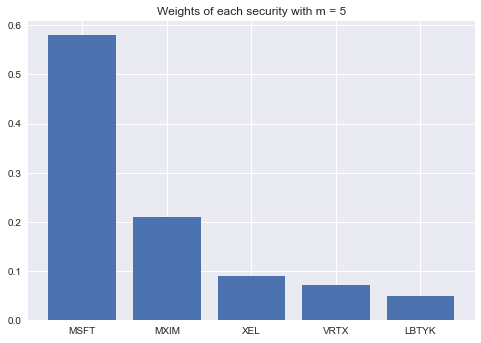

In [19]:
df = pd.DataFrame({'s':stocks_picked, 'w':weight}).sort_values(by='w', ascending=False)
plt.bar(df['s'], df['w'])
plt.title('Weights of each security with m = 5')
plt.show()

## Question 2.
Find the best 5 stocks to include in your portfolio and the weights of those 5
stocks, using the 2019 data. How well does this portfolio track the index in 2020?

In [20]:
stocks_picked

['LBTYK', 'MXIM', 'MSFT', 'VRTX', 'XEL']

In [21]:
weight

array([0.04886175, 0.21038806, 0.58035198, 0.07119022, 0.089208  ])

In [22]:
## evaluation data frame, which is the daily returns in 2020 for stocks we picked into the portfolio
evaluate_df = return20[['NDX']+stocks_picked].iloc[1:,:]
evaluate_df

,NDX,LBTYK,MXIM,MSFT,VRTX,XEL
X,,,,,,
2020-01-03,-0.008827,-0.016204,-0.017299,-0.012452,-0.006699,0.004809
2020-01-06,0.006211,0.015059,-0.018093,0.002585,0.027755,-0.001436
2020-01-07,-0.000234,-0.007881,0.022576,-0.009118,-0.001071,-0.002077
2020-01-08,0.007452,-0.043458,-0.000325,0.015928,0.032620,-0.000961
2020-01-09,0.008669,-0.024426,0.007308,0.012493,-0.003592,0.002244
...,...,...,...,...,...,...
2020-09-24,0.005828,0.003982,0.005573,0.012962,-0.002615,0.013295
2020-09-25,0.023371,0.015865,0.008775,0.022787,0.019192,0.021321
2020-09-28,0.019130,0.019522,0.037998,0.007795,-0.001678,0.005109


We evaluate the performance by calculating:
$$\sum_{t=1}^T |q_t-\sum_{i=5}^5 w_ir_{it}|$$
where $w_i$ is from our previous calculation and $q_t$, $r_{it}$ are based on 2020 data

In [23]:
T = len(evaluate_df)
res = 0
for time in range(T):
    qt = evaluate_df.iloc[time]['NDX']  # index return
    ret = evaluate_df.iloc[time][stocks_picked].to_list()  # stocks returns 
    res += abs(qt - np.dot(weight, ret))
res

0.8696699433741908

## Question 3.
Redo step (2) with m = 10, 20, ..., 90, 100. Analyze the performance of the portfolio for each value of m. How does the performance change? Is there some value of m, where there are diminishing returns of including more stocks in the portfolio? You can also look at the in- sample performance. That is, evaluate the performance in 2019 using 2019 portfolio construction and 2019 data. How is performance in 2019 different than performance in 2020? Why is it different?

In [24]:
'''
INPUTS: 
df: input csv file
date_col: column of Date
idx_col: column of tracking index
m: number of stocks to pick

OUTPUTS: 
m stocks
'''
def stock_picking(df, date_col, idx_col, m): 
    returns = df.set_index(date_col).pct_change()
    
    # number of stocks (other than the index) available
    n = len(returns.columns)-1 
    
    # if there are more or fewer than 100 stocks in csv file, stop at right place
    if n > 100:
        n = 100
        
    corr_mat = returns.drop(columns=idx_col).corr()
    d = len(corr_mat)
    # for i in range(d):
    #    corr_mat.iloc[i,i] = -2   # this ensures that xii won't be selected as the best representative

    rhos = []
    for i in range(n):
        for j in range(n):
            rhos.append(corr_mat.iloc[i,j])

    #### OBJECTIVE FUNCTION ####
    ## MAXIMIZE x1,1 + x1,2 + ... + x1,n + x2,1 + ... + x2,n + ... + xn,n + 0*(y1 + y2 + ... + yn)
    ## obj dimension is n*n + n ##
    obj = np.array(rhos + [0] * n)
    
    #### CONSTRAINT MATRIX ####
    A = np.zeros((1+n+n*n, len(obj))) 

    # y1+y2+...+yn = m
    A[0][-n:] = [1]*n  
    
    # xij = 1 for i = 1,2,...,n
    start_col = 0  
    for i in range(n):
        vec = np.array([1]*n)
        A[i+1, start_col:start_col + n] = vec
        start_col += n
    
    # xij - yj ≤ 0 for i,j = 1,2,...,n
    start_row = 0 + n + 1
    start_col = 0
    for y in range(n,0,-1):
        yj = -y    
        for x in range(n):
            A[start_row + x, yj] = -1
            A[start_row + x, start_col + x*n] = 1
        start_row += n
        start_col += 1
    
    ### ALL DECISION VARIABLES ARE BINARY ###
    vtype = ['B'] * len(obj)
    
    ### RHS and SIGNS ###
    b = np.array([m] + [1]*n + [0]*n*n)
    sense = np.array(['=']*(1+n) + ['<']*n*n)
    
    ### OPTIMIZATION ###
    mod = gp.Model()
    modX = mod.addMVar(len(obj),vtype=vtype)
    cons = mod.addMConstrs(A,modX,sense,b)
    mod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE)
    mod.Params.OutputFlag = 0
    mod.Params.TimeLimit = timeLimit
    mod.optimize()
    
    ### RESULT ###
    stocks_picked = list(modX.x[-n:])
    idx = []
    for i in range(len(stocks_picked)):
        if stocks_picked[i] == 1:
            idx.append(i)
    stocks_picked = corr_mat.columns[idx].to_list()
    return stocks_picked

'''
INPUTS: 
df: input csv file
date_col: column of Date
idx_col: column of tracking index
m: number of stocks to pick
stocks_picked: m stocks in portfolio

OUTPUTS: 
m weights of each stock in portfolio
'''
def finding_weights(df, date_col, idx_col, m, stocks_picked):    
    returns = df.set_index(date_col).pct_change()
    n = len(returns.columns)-1
    port_calculation_df = returns[[idx_col] + stocks_picked].iloc[1:,:]
    
    t = len(port_calculation_df)

    #### OBJECTIVE FUNCTION ####
    # y1+...+yt+ (0*w1+...+0*wm)
    obj = np.array([1]*t + [0]*m)
    
    #### CONSTRAINT MATRIX and RHS ####
    # y1+w1r11+w2r21+w3r31+w4r41+w5r51 ≥ q1  => coef: [1,r11,r21,r31,r41,r51]
    # y1-w1r11-w2r21-w3r31-w4r41-w5r51 ≥ -q1  => coef: [1,-r11,-r21,-r31,-r41,-r51]
    # ...
    
    # w1+w2+...+w5=1
    A = np.zeros((2*t+1, len(obj)))
    b = np.zeros(2*t+1)
    sense = np.array(['>']*2*t+['='])

    i = 0
    y = 0
    for row in range(len(port_calculation_df)):
        qt = port_calculation_df.iloc[row]['NDX']
        rit = port_calculation_df.iloc[row][stocks_picked].to_list()
        # two yt's
        A[i, y], A[i+1, y] = 1, 1 
        # for each row related to yt, add coefs for each weight (which is the return of each picked stock)
        A[i, t:] = rit
        A[i+1, t:] = [-x for x in rit]
        # RHS is the return of index at time t
        b[i], b[i+1] = qt, -qt
        i += 2
        y += 1
    
    # last row, all weights sum up to 1
    A[-1,-m:] = [1]*m
    b[-1] = 1
    
    ### OPTIMIZATION ###
    mod = gp.Model()
    modX = mod.addMVar(len(obj))
    cons = mod.addMConstrs(A,modX,sense,b)
    mod.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)
    mod.Params.OutputFlag = 0
    mod.Params.TimeLimit = timeLimit
    mod.optimize()
    
    ### RESULT ###
    weight = modX.x[-m:]
    return weight


'''
INPUTS: 
df_train: input csv file (to pick stocks and calculate weights)
df_test: csv file for evaluating performance
date_col: column of Date
idx_col: column of tracking index
m: number of stocks to pick

OUTPUTS: 
stocks picked, weight of each stock, evaluation score
'''
def evaluation(df_train, df_test, date_col, idx_col, m):
    stocks_picked = stock_picking(df_train, date_col, idx_col, m)
    weight = finding_weights(df_train, date_col, idx_col, m, stocks_picked)
    
    ## calculate daily returns for testing data
    returns = df_test.set_index(date_col).pct_change()
    ## extract columns we need for evaluation
    evaluate_df = returns[[idx_col]+stocks_picked].iloc[1:,:]
    
    n = len(returns)-1
    T = len(evaluate_df)

    res = 0
    for time in range(T):
        qt = evaluate_df.iloc[time][idx_col]
        ret = evaluate_df.iloc[time][stocks_picked].to_list()
        res += abs(qt - np.dot(weight, ret))
    return stocks_picked, weight, res

In [25]:
# pre-defined ranges of m
ranges = [x for x in range(10,101,10)]
ranges

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

### Evaluate the performance (with 2020 stock data)

In [26]:
df19 = pd.DataFrame(columns=['m','performance'])
df19_portfolio = pd.DataFrame(columns=['m','ticker', 'weight'])

df19['m'] = pd.Series(ranges)

perf = []
for m in ranges:
    stocks_picked, weight, res = evaluation(stock19, stock20, 'X', 'NDX', m)
    perf.append(res)

    # add rows of stocks and weights to the dataframe
    out_temp = pd.DataFrame({'m':[m]*m, 'ticker':stocks_picked, 'weight':weight})
    df19_portfolio = df19_portfolio.append(out_temp)

df19['performance'] = pd.Series(perf)

In [27]:
df19

,m,performance
0,10,0.831317
1,20,0.622036
2,30,0.551833
3,40,0.571485
4,50,0.581148
5,60,0.879273
6,70,0.635728
7,80,0.386431
8,90,0.249824
9,100,0.249943


### Display the top 5 securities in the portfolio for each m

In [28]:
df19_portfolio = df19_portfolio.sort_values(by=['m','weight'], ascending=False)
df_top5_out = pd.DataFrame(columns=['m','stock1','stock2','stock3','stock4','stock5','total'])
for m in ranges:
    df_top5 = df19_portfolio[df19_portfolio['m'] == m].iloc[:5,:]
    top5s = []
    ttl_weight = 0
    for idx, row in df_top5.iterrows():
        s_and_w = row.loc['ticker'] + ' - ' + str(round(row.loc['weight'], 3))
        top5s.append(s_and_w)
        ttl_weight += row.loc['weight']
    df_top5_out.loc[len(df_top5_out)] = [m] + [x for x in top5s] + [round(ttl_weight,3)]
df_top5_out

,m,stock1,stock2,stock3,stock4,stock5,total
0,10,MSFT - 0.482,MXIM - 0.163,ROST - 0.09,XEL - 0.066,VRTX - 0.057,0.858
1,20,MSFT - 0.289,GOOGL - 0.184,MXIM - 0.108,CHTR - 0.067,ANSS - 0.058,0.706
2,30,MSFT - 0.218,GOOGL - 0.152,MXIM - 0.084,PEP - 0.065,BKNG - 0.056,0.573
3,40,MSFT - 0.195,GOOGL - 0.138,MXIM - 0.057,AMGN - 0.049,CTSH - 0.049,0.487
4,50,MSFT - 0.173,GOOGL - 0.13,MXIM - 0.055,CTSH - 0.043,AMAT - 0.038,0.438
5,60,GOOGL - 0.152,CMCSA - 0.073,ADBE - 0.051,CSCO - 0.048,EBAY - 0.045,0.369
6,70,MSFT - 0.188,GOOGL - 0.112,FB - 0.062,CSCO - 0.042,PEP - 0.041,0.445
7,80,MSFT - 0.164,AAPL - 0.099,GOOGL - 0.097,FB - 0.06,NFLX - 0.032,0.452
8,90,MSFT - 0.107,AAPL - 0.102,AMZN - 0.095,GOOG - 0.085,FB - 0.048,0.436
9,100,AAPL - 0.102,MSFT - 0.101,AMZN - 0.096,GOOGL - 0.057,FB - 0.047,0.403


### In-sample evaluation (with 2019 stock data)

In [29]:
# in-sample performance
df19_in = pd.DataFrame(columns=['m','performance'])
df19_in['m'] = pd.Series(ranges)
df19_in_portfolio = pd.DataFrame(columns=['m','ticker', 'weight'])
perf_in = []
for m in ranges:
    stocks_picked, weight, res = evaluation(stock19, stock19, 'X', 'NDX', m)
    perf_in.append(res)
df19_in['performance'] = pd.Series(perf_in)

In [30]:
df19_in

,m,performance
0,10,0.686533
1,20,0.466268
2,30,0.409792
3,40,0.363281
4,50,0.332540
5,60,0.352056
6,70,0.233143
7,80,0.147683
8,90,0.053827
9,100,0.044911


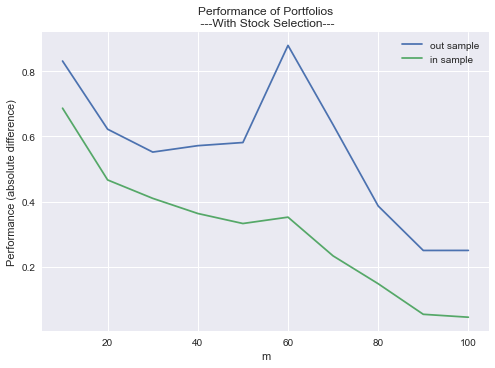

In [31]:
plt.plot(df19['m'], df19['performance'], label='out sample')
plt.plot(df19_in['m'], df19_in['performance'], label='in sample')
plt.title('Performance of Portfolios\n ---With Stock Selection---')
plt.legend()
plt.xlabel('m')
plt.ylabel('Performance (absolute difference)')
plt.show()

## Question 4.
Another way you could solve this problem is to completely ignore the stock selection IP and re- formulate the weight selection problem to be an MIP that constrains the number of non-zero weights to be an integer. To do this take the weight selection problem and replace m with n so that you are optimizing over ALL weights.

objective:
$$\min_w \sum_{t=1}^T|q_t-\sum_{i=1}^nw_ir_{it}|$$

Similar to previous question, we introduce new variable $z_t=|q_t-\sum_{i=1}^n w_ir_{it}|$, \
Then the problem becomes: 
$$\min_w \sum_t^n z_t$$
$$z_t≥q_t-\sum_{i=1}^nw_ir_{it} \longrightarrow \sum_{i=1}^nw_ir_{it}+z_t\geq q_t$$
$$z_t≥\sum_{i=1}^nw_ir_{it}-q_t \longrightarrow -\sum_{i=1}^nw_ir_{it}+z_t\geq -q_t$$

Define $y_i$ as whether stock $i$ is in fund. And have big M as 1. 

$$w_i-My_i\leq 0$$
$$y_1+...+y_n=m$$

### We choose big M to be 1 because $w_i$ is weight and there's no weight greater than 1

In [32]:
ranges = [5] + ranges
ranges

[5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [33]:
'''
INPUTS: 
df_train: input csv file (to pick stocks and calculate weights)
df_test: csv file for evaluating performance
date_col: column of Date
idx_col: column of tracking index
m: number of stocks to pick

OUTPUTS: 
dataframe (stocks picked and weights of each), evaluation score
'''
def evaluate_M(df_train, df_test, date_col, idx_col, m):
    return_train = df_train.set_index(date_col).pct_change()
    return_test = df_test.set_index(date_col).pct_change()
    
    ## now we are using the entire daily return table from training table
    w_selection_df = return_train.iloc[1:,:]
    T = len(w_selection_df)
    M = 1  ## big M constraint
    n = len(w_selection_df.columns)-1
    
    
    #### OBJECTIVE FUNCTION ####
    # MINIMIZE 0*(w1+...+wn) + 0*(y1+...+yn) + z1 + z2 + ... + zt
    obj = np.array([0]*(n+n) + [1]*T)
    
    #### CONSTRAINT MATRIX and RHS ####
    A = np.zeros((2+n+2*T, len(obj)))
    b = np.zeros(2+n+2*T)
    sense = np.array(['=']*2 + ['<']*n + ['>']*2*T)
    
    #### wi and zi are constants; yj is binary
    vtypes = np.array(['C']*n + ['B']*n + ['C']*T)
    
    # sum of wi = 1
    A[0, :n] = 1  
    b[0] = 1
    
    # sum of yi = m
    A[1, n:2*n] = 1   
    b[1] = m

    # wi - Myi ≤ 0
    for k in range(n):
        A[2+k, [k, k+n]] = [1,-M]

    i = 2+n  # row of first zi variable in A
    z = 2*n  # column of first zi variable in A
    for row in range(len(w_selection_df)):
        qt = w_selection_df.iloc[row]['NDX']
        rit = w_selection_df.iloc[row, 1:].to_list()
        # two zt's
        A[i, z], A[i+1, z] = 1, 1  
        # for each row related to yt, add coefs for each weight (which is the return of each picked stock)
        A[i, :n] = rit
        A[i+1, :n] = [-x for x in rit]
        # RHS is the return of index at time t
        b[i], b[i+1] = qt, -qt
        i += 2
        z += 1
    
    #### OPTIMIZATION ####    
    mod = gp.Model()
    modX = mod.addMVar(len(obj), vtype=vtypes)
    cons = mod.addMConstrs(A,modX,sense,b)
    mod.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)
    mod.Params.OutputFlag = 0
    mod.Params.TimeLimit = timeLimit   ### this needs to be changed!!
    mod.optimize()
    
    #### RESULT ####
    stock_ = list(modX.x[n:2*n])
    weights = modX.x[:n]
    idx = []
    for i in range(len(stock_)):
        if stock_[i] == 1:
            idx.append(i)
    stocks = pd.DataFrame(columns=['m','ticker', 'weight'])
    stocks['m'] = pd.Series([m]*m)
    
    stocks.ticker = pd.Series(return19.drop(columns='NDX').columns[idx])
    stocks.weight = pd.Series(weights[idx])
    
    #### EVALUATION ####
    comp = return_test[[idx_col] + stocks.ticker.to_list()].iloc[1:,:]
    T = len(comp)
    res = 0
    for time in range(T):
        qt = comp.iloc[time]['NDX']
        ret = comp.iloc[time][stocks.ticker.to_list()].to_list()
        res += abs(qt - np.dot(stocks.weight, ret))
    return stocks, res

### Performance evaluation (both in sample and out sample evaluation)

In [34]:
'''
FINAL IMPLEMENTATION
'''
def question4(ms):
    # output file for each portfolio details
    portfolio = pd.DataFrame(columns=['m','ticker', 'weight'])
    
    # output file for each m performance/evaluation
    performance = pd.DataFrame(columns=['m', 'performance_out_of_sample', 'performance_in_sample'])
    for m in ms:
        # evaluation using 2020 returns
        output_df, res_out = evaluate_M(stock19, stock20, 'X', 'NDX', m)  

        # in-sample evaluation using 2019 returns
        _, res_in = evaluate_M(stock19, stock19, 'X', 'NDX', m)  
        
        # add rows of stocks and weights to the dataframe
        portfolio = portfolio.append(output_df)
        
        # add performance scores to performance
        performance.loc[len(performance)] = [int(m), res_out, res_in]

    portfolio.to_csv('portfolio.csv', index=False)
    performance.to_csv('performance.csv', index=False)
    
    return portfolio, performance

In [35]:
import os
if os.path.exists('portfolio.csv') and os.path.exists('performance.csv'):
    portfolio = pd.read_csv('portfolio.csv')
    performance = pd.read_csv('performance.csv')
else:
    portfolio, performance = question4(ranges)

### top 5 securities for each m

In [36]:
portfolio = portfolio.sort_values(by=['m','weight'], ascending=False)
df_top5_M = pd.DataFrame(columns=['m','stock1','stock2','stock3','stock4','stock5','total'])
for m in ranges:
    df_top5 = portfolio[portfolio['m'] == m].iloc[:5,:]
    top5s = []
    ttl_weight = 0
    for idx, row in df_top5.iterrows():
        s_and_w = row.loc['ticker'] + ' - ' + str(round(row.loc['weight'], 3))
        ttl_weight += row.loc['weight']
        top5s.append(s_and_w)
    df_top5_M.loc[len(df_top5_M)] = [m] + [x for x in top5s] + [round(ttl_weight,3)]
df_top5_M

,m,stock1,stock2,stock3,stock4,stock5,total
0,5,MSFT - 0.29,AMZN - 0.25,AAPL - 0.192,MDLZ - 0.155,ADI - 0.114,1.000
1,10,MSFT - 0.149,PAYX - 0.144,AAPL - 0.135,AMZN - 0.13,GOOG - 0.087,0.646
2,20,AAPL - 0.124,GOOGL - 0.105,AMZN - 0.105,MSFT - 0.09,FB - 0.049,0.473
3,30,AAPL - 0.114,AMZN - 0.102,GOOGL - 0.094,MSFT - 0.093,ADP - 0.047,0.450
4,40,AAPL - 0.11,MSFT - 0.103,AMZN - 0.099,GOOGL - 0.084,FB - 0.054,0.450
5,50,MSFT - 0.109,AAPL - 0.101,AMZN - 0.098,GOOG - 0.086,FB - 0.049,0.442
6,60,AAPL - 0.1,AMZN - 0.099,MSFT - 0.098,GOOGL - 0.086,FB - 0.053,0.436
7,70,MSFT - 0.1,AAPL - 0.099,AMZN - 0.096,GOOGL - 0.088,FB - 0.048,0.431
8,80,MSFT - 0.104,AAPL - 0.103,AMZN - 0.096,GOOGL - 0.057,FB - 0.048,0.408
9,90,AAPL - 0.102,MSFT - 0.101,AMZN - 0.096,GOOGL - 0.056,FB - 0.047,0.402


In [37]:
performance

,m,performance_out_of_sample,performance_in_sample
0,5,0.591398,0.499259
1,10,0.549379,0.301498
2,20,0.396847,0.156564
3,30,0.365593,0.105641
4,40,0.312313,0.079523
5,50,0.258456,0.062166
6,60,0.256977,0.052650
7,70,0.254183,0.050359
8,80,0.249143,0.045227
9,90,0.250194,0.044911


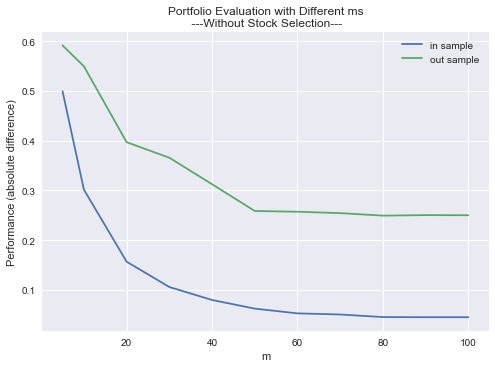

In [38]:
#plt.figure(figsize=(15,7))
plt.plot(performance['m'], performance.performance_in_sample, label='in sample')
plt.plot(performance['m'], performance.performance_out_of_sample, label='out sample')
plt.legend()
plt.xlabel('m')
plt.ylabel('Performance (absolute difference)')
plt.title('Portfolio Evaluation with Different ms\n ---Without Stock Selection---')
plt.show()

In [39]:
# for m in portfolio['m'].unique().tolist():
#     plt.figure(figsize=(18,6))
#     port_sort = portfolio[portfolio['m'] == m].sort_values(by='weight', ascending=False)
#     stocks = port_sort['ticker']
#     weights = port_sort['weight']
#     plt.bar(stocks,weights)
#     plt.xticks(rotation=80)
#     plt.title('Weights of each security with m = {}'.format(m))
#     plt.savefig("output_{}.jpg".format(m))
#     plt.show()